In [2]:
%matplotlib inline

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
from importlib import reload

In [5]:
import nb_import
nb_import = reload(nb_import)
from nb_import import *

In [6]:
import tools
tools = reload(tools)

# Datasets

In [57]:
(X_train, y_train, X_test, y_test) = tools.get_dataset('mnist-70k')

In [191]:
# plt.imshow(X_train[0].reshape(8,8))

# default TSNE

In [11]:
from openTSNE import TSNE

In [12]:
res_tsne = []
tsne = TSNE(n_jobs=8,
            initialization='pca',
            callbacks=lambda it, err, emb: res_tsne.append((it, err)),
            callbacks_every_iters=1,
           )

In [13]:
%time embd_tsne = tsne.fit(X_train)

CPU times: user 5min 49s, sys: 21.7 s, total: 6min 11s
Wall time: 53.9 s


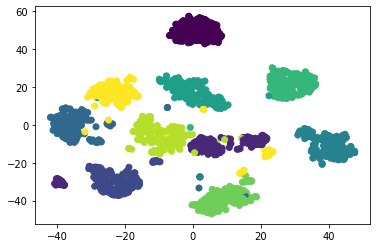

In [14]:
fig, ax = plt.subplots()
ax.scatter(embd_tsne[:,0], embd_tsne[:,1], c=y_train, rasterized=True)

In [15]:
res_tsne = np.array(res_tsne)

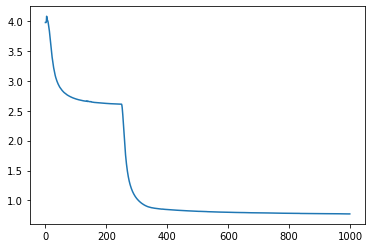

In [16]:
plt.plot(res_tsne[:,1])

In [17]:
tools.K_NN_classifier(embd_tsne, y_train)

0.9933333333333333

# default force

In [19]:
%time affinities_N = affinity.PerplexityBasedNN(X_train)

CPU times: user 5.67 s, sys: 21.1 ms, total: 5.7 s
Wall time: 5.5 s


In [20]:
%time init_pca = initialization.pca(X_train, random_state=42)

CPU times: user 21.9 ms, sys: 7.86 ms, total: 29.8 ms
Wall time: 7.09 ms


In [21]:
import networkx as nx
from fa2 import ForceAtlas2

In [26]:
# Create ForceAtlas2 object with desired parameters
forceatlas2 = ForceAtlas2(
                          # Behavior alternatives
                          outboundAttractionDistribution=True,  # Dissuade hubs
                          linLogMode=False,  # NOT IMPLEMENTED
                          adjustSizes=False,  # Prevent overlap (NOT IMPLEMENTED)
                          edgeWeightInfluence=1.0,

                          # Performance
                          jitterTolerance=1.0,  # Tolerance
                          barnesHutOptimize=True,
                          barnesHutTheta=1.2,
                          multiThreaded=False,  # NOT IMPLEMENTED

                          # Tuning
                          scalingRatio=2.0,
                          strongGravityMode=False,
                          gravity=1.0,

                          # Log
                          verbose=True)

In [27]:
# run forceatlas2
%time positions = forceatlas2.forceatlas2(affinities_N.P, pos=init_pca, iterations=1000)

100%|██████████| 1000/1000 [00:18<00:00, 52.67it/s]

BarnesHut Approximation  took  9.41  seconds
Repulsion forces  took  7.10  seconds
Gravitational forces  took  0.09  seconds
Attraction forces  took  1.61  seconds
AdjustSpeedAndApplyForces step  took  0.36  seconds
CPU times: user 19.6 s, sys: 78.2 ms, total: 19.6 s
Wall time: 19.6 s


In [28]:
positions = np.array(positions)

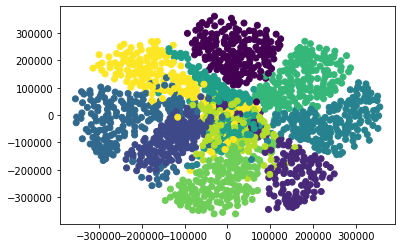

In [29]:
fig, ax = plt.subplots()
ax.scatter(positions[:,0], positions[:,1], c=y_train, rasterized=True)

In [205]:
tools.K_NN_classifier(positions, y_train)

0.312

# networkx

In [206]:
import networkx as nx

In [211]:
G = nx.from_scipy_sparse_matrix(affinities.P)

In [214]:
%time res = nx.spring_layout(G, iterations=1)

CPU times: user 4min 37s, sys: 938 ms, total: 4min 38s
Wall time: 4min 37s


# hybrid

## step 1 - sample $\sqrt{N}$

In [78]:
N = X_train.shape[0]
# rootN = np.int(np.sqrt(N))
rootN = np.max((np.int(np.sqrt(N)), 1000))

In [79]:
rootN_ids = np.random.choice(N, size=rootN, replace=False)

In [80]:
rootN_data = X_train[rootN_ids]

## step 2 - force-based layout

In [81]:
from openTSNE import affinity, initialization

In [82]:
init_pca = initialization.pca(rootN_data, random_state=42)

In [83]:
affinities_rootN = affinity.PerplexityBasedNN(rootN_data)

In [46]:
# import scipy.sparse as ss

# # affinities_rootN_Pinv = ss.linalg.(affinities_rootN.P)
# M = affinities_rootN.P
# Minv = np.reciprocal(M.data)
# Minv = ss.csr_matrix((Minv, M.nonzero()))

In [303]:
# from sklearn import preprocessing
# init_force = preprocessing.scale(Minv, with_mean=False)

In [84]:
import networkx as nx
from fa2 import ForceAtlas2

In [85]:
# Create ForceAtlas2 object with desired parameters
forceatlas2 = ForceAtlas2(
                          # Behavior alternatives
                          outboundAttractionDistribution=True,  # Dissuade hubs
                          linLogMode=False,  # NOT IMPLEMENTED
                          adjustSizes=False,  # Prevent overlap (NOT IMPLEMENTED)
                          edgeWeightInfluence=1.0,

                          # Performance
                          jitterTolerance=1.0,  # Tolerance
                          barnesHutOptimize=True,
                          barnesHutTheta=1.2,
                          multiThreaded=False,  # NOT IMPLEMENTED

                          # Tuning
                          scalingRatio=2.0,
                          strongGravityMode=False,
                          gravity=1.0,

                          # Log
                          verbose=True)

In [86]:
# run forceatlas2
positions = forceatlas2.forceatlas2(affinities_rootN.P, pos=init_pca, iterations=10000)

100%|██████████| 10000/10000 [01:13<00:00, 135.67it/s]

BarnesHut Approximation  took  27.08  seconds
Repulsion forces  took  33.00  seconds
Gravitational forces  took  0.49  seconds
Attraction forces  took  9.05  seconds
AdjustSpeedAndApplyForces step  took  2.00  seconds


In [87]:
positions_arr = np.array(positions)

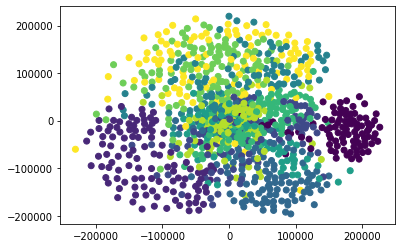

In [88]:
fig, ax = plt.subplots()
ax.scatter(positions_arr[:,0], positions_arr[:,1], c=y_train[rootN_ids], rasterized=True)

## step 3 - coarse layout of $N-\sqrt{N}$

In [104]:
not_rootN_ids = np.zeros(N, dtype=np.int)
not_rootN_ids[rootN_ids] = 1
not_rootN_ids = np.logical_not(not_rootN_ids)

In [105]:
X_remainder = X_train[not_rootN_ids]
X_remainder_nn = affinities.knn_index.query(X_remainder, k=1)

In [106]:
init_force_coarse = np.zeros((N,2))
init_force_coarse[rootN_ids] = positions
init_force_coarse[not_rootN_ids] = np.array(positions)[X_remainder_nn[0].reshape(-1)]

In [108]:
from sklearn import preprocessing
init_force_coarse = preprocessing.scale(init_force_coarse)

## step 4 - TSNE with init

In [107]:
from openTSNE import TSNE, TSNEEmbedding

In [128]:
affinities_N = affinity.PerplexityBasedNN(X_train)

In [129]:
embedding = TSNEEmbedding(
    init_force_coarse,
    affinities_N,
    n_jobs=8,
    
#     callbacks=lambda it, err, emb: res_tsne_force.append((it, err)),
#     callbacks_every_iters=1,
)

In [111]:
%%time

# emb_1 = embedding.optimize(n_iter=250, exaggeration=12, momentum=0.5)
emb_2 = embedding.optimize(n_iter=750, exaggeration=1, momentum=0.8)

CPU times: user 9min 25s, sys: 25.6 s, total: 9min 50s
Wall time: 1min 15s


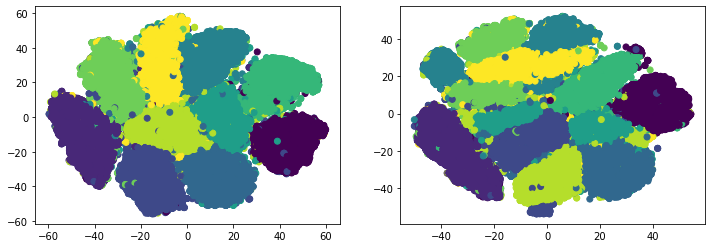

In [122]:
fig, ax = plt.subplots(1,2, figsize=(12,4))
ax[0].scatter(embd_tsne[:,0], embd_tsne[:,1], c=y_train[:N], rasterized=True)
ax[1].scatter(emb_2[:,0], emb_2[:,1], c=y_train, rasterized=True)